The following is adapted from a course project for *ECON 424 - Income Inequality*, at UCLA's Master of Quantitative Economics Program. Done in collaboration with 2 fellow students.

# Introduction and Motivation
Americans have a wide variety of choices to make concerning their career and education once they complete K-12. One avenue, the Associate's degree, has not been examined as often as higher degrees or abstaining from college altogether. While only a small minority choose the route of only an Associate's, or 2-year, degree, it is important to understand the wage premiums associated with it, so young persons can be better informed about their choices.

Using a sample of U.S. Census data, we examine descriptive statistics on income for 4 levels of educational attainment and apply regression methods to parse out the value of a secondary education relative to only receiving a High School Diploma/GED, with a focus on the unique position of holding an Associate's degree. We find that while other degrees have generally increased in value relative to only finishing High School, the relative value of an Associate's degree has decreased over time, particularly after the Great Financial Crisis.

# Import Libraries

In [1]:
# Standard Library
import datetime as dt
from IPython.display import display

# Third-party
## Misc
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from tqdm.notebook import tqdm

## Statistics
import statsmodels.api as sm

## Plotting/Tables
import matplotlib.pyplot as plt
import seaborn as sns
from stargazer.stargazer import Stargazer, LineLocation


# Load and customize IPUMS data
This project uses a sample from the U.S. Census Bureau 2000-2019 American Community Survey 5-year estimates, retrieved from  [IPUMS USA](https://usa.ipums.org/usa/). This sample represents 0.1\% of the full survey. For readability, the full data exploration is not included in this workbook.

In [3]:
# Read in IPUMS extract file
df = pd.read_stata('usa_00005.dta/usa_00005.dta', convert_categoricals=False)

## Create bins for highest level of education
Going forward, all references to education specifically mean highest level of education.

In [4]:
# Create bins aggregating related education levels
df["educbin"] = pd.cut(df["educd"], 
                       bins = [-1, 1,   # Missing
                               61,   # Didn't Finish K-12
                               80,   # Finished HS/College Dropout
                               83,   # Associate's Degree
                               100,  # Finished HS/College Dropout
                               101,  # Bachelor's Degree
                               113,  # Finished HS/College Dropout
                               116,  # Masters Degree
                               999],  # Missing 
                       labels = False) 

# Create a DataFrame for educational bins in string format
educ_nums = [i for i in range(9)]
educ_str = [np.nan, "K-12 Dropout", "HS Diploma/GED", "Associate's",
            "HS Diploma/GED", "Bachelor's","HS Diploma/GED",
            "Advanced", np.nan]
educ_df = pd.DataFrame({'educbin':educ_nums, 'educstr':educ_str})

# Concatenate education strings to main dataframe
df = df.merge(educ_df, how = 'left', on = 'educbin')

# Remove observations with less than high school diploma
df = df[df['educbin'] != 1]

## Adjust income for inflation
Using the Consumer Price Index from the Federal Reserve Economic Data (FRED) API, adjust wages to 2019 dollars.

In [5]:
# Retrieve CPI from FRED
cpi = web.DataReader("CPIAUCNS", "fred", 
                     dt.datetime(2000,1,1),
                     dt.datetime(2019,12,31))

# Extract annual CPI (Averaged over monthly data)
cpi['year'] = cpi.index.year
annual_cpi = cpi.groupby(['year'], as_index = False)[['CPIAUCNS']].mean()
cpi2019 = annual_cpi.iloc[-1, 1]

# Create CPI-adjusted income variable
df = df.merge(annual_cpi, on = 'year', how = 'left')
df['adj_incwage'] = cpi2019*df['incwage']/df['CPIAUCNS']

# Preview 5 examples of original and adjusted wages
display(df[['year','CPIAUCNS','incwage','adj_incwage']].sample(5).head())


,year,CPIAUCNS,incwage,adj_incwage
752123,2003,183.958333,36000,50031.258890
2999417,2014,236.736167,5200,5615.612457
224199,2001,177.066667,23000,33208.512331
3263661,2015,237.017000,0,0.000000
2934496,2014,236.736167,62000,66955.379301


# Summary Statistics & Plots

## Income quartiles by education level

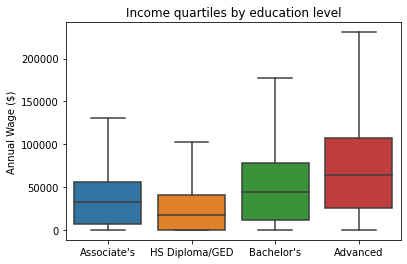

In [6]:
# Plot with Seaborn Boxplot
sns.boxplot(y = 'adj_incwage', x = 'educstr', data = df,
            showfliers = False)
plt.xlabel("")
plt.ylabel("Annual Wage ($)")
plt.title("Income quartiles by education level");

The average (mean) person with a Bachelor's or Advanced degree earns more than those with only an Associate's or High School Diploma/GED. Those with advanced degrees have the most heterogeneity in wages, with the 75th percentile making approx. \\$100,000 and the 25th making \\$25,000. Having no income at all is most common with High School completion.

## Ratio of Persons by Education Level

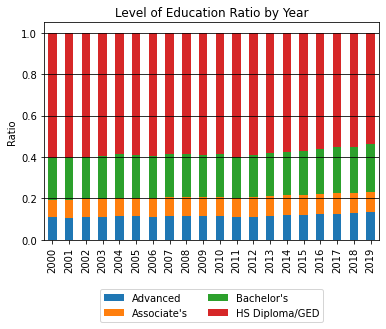

In [7]:
# Create Grouped DataFrame, by year and education level
df_grouped = df.groupby(['year','educstr'], as_index = False)

# Get number of people by year/level of education
grouped_yreduc_count = df_grouped.size()

# Get full count of persons by year
grouped_year_count = grouped_yreduc_count.groupby(['year'], 
                                                  as_index = False).sum()

# Per year, calculate ratio of persons in each education level
grouped_yreduc_ratio = grouped_yreduc_count.merge(grouped_year_count, 
                               how = 'left', on = 'year')
grouped_yreduc_ratio['ratio'] = np.divide(grouped_yreduc_ratio['size_x'],
                                          grouped_yreduc_ratio['size_y'])

# Drop unneeded numerator/denominator
grouped_yreduc_ratio.drop(columns = ['size_x','size_y'], inplace = True)

# Pivot, creating columns for each education level
ed = grouped_yreduc_ratio.copy()
ed = ed.pivot(index = 'year', columns = 'educstr', values = 'ratio')

# Create Plot
ed.plot(kind = 'bar', stacked = True)
plt.title("Level of Education Ratio by Year")
plt.ylabel("Ratio")
plt.xlabel("")
plt.legend(loc = 'lower center', bbox_to_anchor=(0.5,-0.4), ncol = 2)
plt.grid(axis='y', color = 'black')

The share of people with any degree beyond High School completion has risen since 2000, if only subtly. This includes the share of people with an Associate's degree.

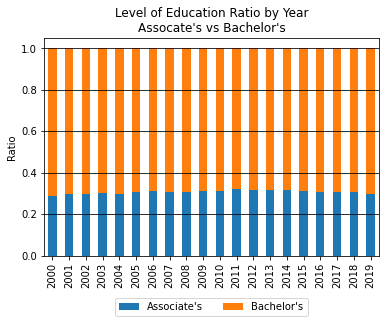

In [8]:
# From previous info on number of people per year/education,
# Create subset comparing only people with an Associate's or
# Bachelor's
as_ba = grouped_yreduc_count[
    np.isin(grouped_yreduc_count.educstr, ["Associate's","Bachelor's"])]

# Repeat previous steps, getting full count of persons per year,
# calculating ratio, and pivoting to create education columns.
as_ba_count = as_ba.groupby(['year'], as_index = False).sum()
as_ba_ratio = as_ba.merge(as_ba_count, 
                               how = 'left', on = 'year')
as_ba_ratio['ratio'] = as_ba_ratio['size_x']/as_ba_ratio['size_y']
as_ba_ratio.drop(columns = ['size_x','size_y'], inplace = True)

as_ba_ed = as_ba_ratio.copy()
as_ba_ed = as_ba_ed.pivot(index = 'year', columns = 'educstr', values = 'ratio')

# Plot
as_ba_ed.plot(kind = 'bar', stacked = True)
plt.title("Level of Education Ratio by Year\nAssocate's vs Bachelor's")
plt.ylabel("Ratio")
plt.xlabel("")
plt.legend(loc = 'lower center', bbox_to_anchor=(0.5,-0.3), ncol = 2)
plt.grid(axis='y', color = 'black');

Both Bachelor's and Associate's Degrees have become more popular over time. Comparing only persons from these two categories, the ratio has remained consistent.
## Difference in Median Wages over time

In [9]:
### Using previous grouped Datarame, get 
# median wages by year and education level
grouped_med_wages = df_grouped[['adj_incwage']].median()

# Pivot median wages, creating a column for each education level
grouped_med_wages = grouped_med_wages.pivot(index = 'year', 
                                            columns = 'educstr', 
                                            values = 'adj_incwage')

# Calculate differences between Associates degree and Bachelor's degree or HS diploma
grouped_med_wages['Assoc-Bach'] = np.subtract(grouped_med_wages["Associate's"],
                                              grouped_med_wages["Bachelor's"])
grouped_med_wages['Assoc-HS/GED'] = np.subtract(grouped_med_wages["Associate's"],
                                                grouped_med_wages['HS Diploma/GED'])

In [10]:
# Define function for adding a shaded bar to 
# a matplotlib time series plot to illustrate
# the 2007-2009 Recession
def recession(plt):
    plt.axvspan(2008,2010,color="grey",alpha=0.25)

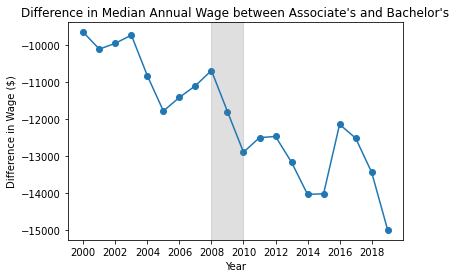

In [11]:
# Plot Median wage difference over time 
# between Associate's and Bachelor's Degrees
plt.plot(grouped_med_wages['Assoc-Bach'])
plt.scatter(grouped_med_wages.index, grouped_med_wages['Assoc-Bach'])
plt.title("Difference in Median Annual Wage between Associate's and Bachelor's")
plt.ylabel("Difference in Wage ($)")
plt.xlabel("Year")
plt.xticks(grouped_med_wages.index[0::2])
recession(plt);

The wage premium for people with an Associate's degree as their highest degree compared to those with a Bachelor's degree has decreased over time. As a reminder, income has been adjusted for inflation.

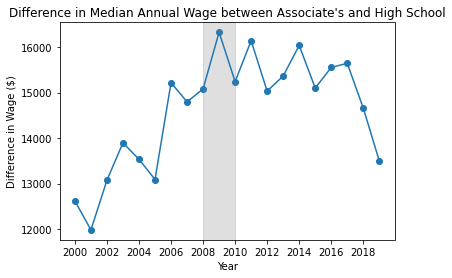

In [12]:
# Plot difference over time between Associate's Degree and High School Diploma
plt.plot(grouped_med_wages['Assoc-HS/GED'])
plt.scatter(grouped_med_wages.index, grouped_med_wages['Assoc-HS/GED'])
plt.title("Difference in Median Annual Wage between Associate's and High School")
plt.ylabel("Difference in Wage ($)")
plt.xlabel("Year")
plt.xticks(grouped_med_wages.index[0::2])
recession(plt);

The wage premium for people with an Associate's degree versus a High School Diploma/GED grew until 2008, where it stagnated, then declined after 2016.

## Year-Over-Year Changes in Median Income

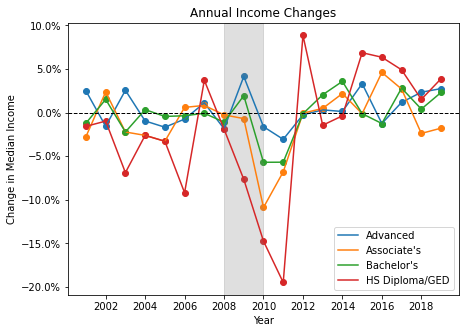

In [13]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(figsize=(7,5))

for educ in grouped_med_wages.columns[0:4]:
    
    ax.scatter(grouped_med_wages.index,
                grouped_med_wages[educ].pct_change()*100)
    
    ax.plot(grouped_med_wages.index,
             grouped_med_wages[educ].pct_change()*100,
             label=educ)
    
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.xticks(grouped_med_wages.index[0::2])
plt.legend(loc='lower right')
plt.title("Annual Income Changes")
plt.xlabel("Year")
plt.ylabel("Change in Median Income")
plt.axhline(0, color = "black", linestyle="dashed", linewidth=1)
recession(plt);

During the Great Financial Crisis, the lower the level of education, the more wages declined. The median wage associated with an advanced degree remained generally the same, while lower levels of education sharply decreasd. Wages for Associate's degrees did not see an increase until 2013.
# Prepare Data for Regressions
There are 3 classes of predictive variables used:
1. Indicators for level of education: Associate's, Bachelor's, or Advanced. High School only is the base value.
2. Personal Controls: Race indicators, age, and an indicator if the person is female.
3. Structural Controls: Indicators for employment and citizenship status.

In [14]:
# Get outcome variable: Log Wages
# Log(0) is undefined, replace with log(1) = 0
y = np.log(
    df["adj_incwage"].replace(0,1) 
)

# Rename column for better display in stargazer table
y.rename("Log Annual Wage",inplace=True)

# Create dummy variables for factor of interest: Level of Education
X = pd.get_dummies(
    df["educstr"]
).drop("HS Diploma/GED", axis=1) # HS Diploma/GED is base value

# Current format is 1 for Male, 2 for Female.
# Subtract 1 to create indicator variable: 1/True = Female
df["fem"] = df["sex"] - 1 

# Separate "Personal" control variables
# and generate dummies for race/ethnicity
control_columns1 = ["race","age","fem"]
c1 = pd.get_dummies(df[control_columns1],
                    columns=["race"],
                    drop_first=True)

# Separate "Structural" control variables
# and generate dummies for both of them
control_columns2 = ["empstat","citizen"]
c2 = pd.get_dummies(df[control_columns2],
                    columns=["empstat","citizen"],
                    drop_first=True)

# Estimate Log-Linear Regressions
I perform 3 rounds of regressions:
1. The full sample of observations with at least a high school diploma or GED
2. Observations from the last sample with non-zero income
3. Observations with non-zero income, with separate regressions for each year

## 1. Full Sample

In [15]:
# Create 3 sets of variables

# Education level only
X1 = sm.add_constant(X)

# Education + Personal Controls
X2 = pd.concat([X1, c1], axis=1)

# Education + Personal Controls + Structural Controls
X3 = pd.concat([X2, c2], axis=1)

In [16]:
# Run 3 regressions

# Education level only
ols1 = sm.OLS(y,X1).fit()

# Education + Personal Controls
ols2 = sm.OLS(y,X2).fit()

# Education + Personal Controls + Structural Controls
ols3 = sm.OLS(y,X3).fit()

In [17]:
# Compare results in a Stargazer table
models = [ols1,ols2,ols3]

table = Stargazer(models)
table.covariate_order(["Associate's","Bachelor's","Advanced"])
table.add_line("Personal Controls", ["No","Yes","Yes"], 
                LineLocation.FOOTER_TOP)
table.add_line("Structural Controls", ["No","No","Yes"], 
               LineLocation.FOOTER_TOP)
table.show_degrees_of_freedom(False)

display(table)

This regression estimates that on average, compared to those with a High School Diploma or GED:
- Associate's Degree holders earn 39% more
- Bachelor's Degree holders earn 65% more
- Advanced Degree holders earn 100% more

## 2. With Income greater than 0

In [18]:
# Get indexes of observations with positive income
pos_income_ind = np.where(df["adj_incwage"] > 0)

# Subset variable collections using indexes
yb = y.iloc[pos_income_ind]
X1b = X1.iloc[pos_income_ind]
X2b = X2.iloc[pos_income_ind]
X3b = X3.iloc[pos_income_ind]

In [19]:
# Run same 3 regressions on subset of data
ols1b = sm.OLS(yb,X1b).fit()
ols2b = sm.OLS(yb,X2b).fit()
ols3b = sm.OLS(yb,X3b).fit()

In [20]:
# Compare results in a stargazer table
models_b = [ols1b,ols2b,ols3b]

table_b = Stargazer(models_b)
table_b.covariate_order(["Associate's","Bachelor's","Advanced"])
table_b.add_line("Personal Controls", ["No","Yes","Yes"], 
                LineLocation.FOOTER_TOP)
table_b.add_line("Structural Controls", ["No","No","Yes"], 
               LineLocation.FOOTER_TOP)
table_b.show_degrees_of_freedom(False)

display(table_b)

Limiting the sample to only those with positive income reduces the impact of different degrees. For those with any income, compared to those with a High School Diploma or GED:
- Associate's Degree holders earn 28% more
- Bachelor's Degree holders earn 58% more
- Advanced Degree holders earn 86% more

## 3. Annual Models

In [21]:
# Define function which, given a dataframe containing all
# regression variables, creates dummies where necessary,
# estimates regression, and returns coefficients for
# level of education.
def get_educ_coef(df):
    y = np.log(df["adj_incwage"])

    educ = pd.get_dummies(df["educstr"]
                         ).drop("HS Diploma/GED", axis=1)
    
    controls = pd.get_dummies(df[["race","age","fem",
                                 "empstat","citizen"]],
                              columns=["race","empstat",
                                       "citizen"],
                              drop_first=True)
    
    X = pd.concat([educ,controls], axis=1)
    
    ols = sm.OLS(y,sm.add_constant(X)).fit()
    educ_params = ols.params[["Advanced",
                              "Bachelor's",
                              "Associate's"]]
    
    return(educ_params)

# Apply indices of positive income to full dataframe
pos_income_df = df.iloc[pos_income_ind]

# Create a vector of years (which will be iterated over)
years = np.arange(2000,2020,1)

# Initialize empty lists for education level coefs
adv_list = []
bac_list = []
asc_list = []

# Iterate over years, creating a new subset of data for 
# each year and estimating regression parameters
for year in tqdm(years):
    subset_df = pos_income_df[pos_income_df["year"] == year]
    coef = get_educ_coef(subset_df)
    adv_list.append(coef["Advanced"])
    bac_list.append(coef["Bachelor's"])
    asc_list.append(coef["Associate's"])
    
# Assemble coefficients and years into a dataframe
# for plotting convenience
annual_coef_df = pd.DataFrame({"Year": years,
                          "Associate's":asc_list,
                          "Bachelor's":bac_list,
                          "Advanced":adv_list})
    

  0%|          | 0/20 [00:00<?, ?it/s]

In [22]:
# Define function to plot coefficient differences over time
def plot_educ_coef(educ_level):
    plt.plot(annual_coef_df['Year'], annual_coef_df[educ_level])
    plt.scatter(annual_coef_df['Year'], annual_coef_df[educ_level])
    plt.title(f"Coefficient of {educ_level} Degree by Year")
    plt.xlabel('Year')
    plt.ylabel('Coefficient')
    plt.xticks(annual_coef_df['Year'][0::2])
    recession(plt);

Using the 3rd regression specification (Education, Personal & Structural Controls), I repeat each regression on a different dataset, each subset by year. Plotted below are educational regression coefficients for each of these annual models.

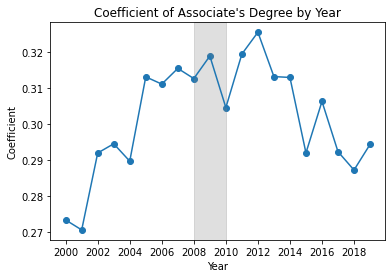

In [23]:
plot_educ_coef("Associate's")

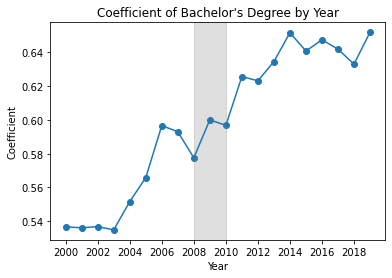

In [24]:
plot_educ_coef("Bachelor's")

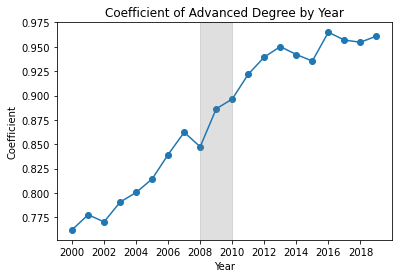

In [25]:
plot_educ_coef("Advanced")

From 2000, every kind of degree predicted higher wages compared to only a High School diploma, and this wage premium increased over time for every kind of secondary degree. However, after the GFC, wage premiums from an Associates degree began decreasing every year, while continuing to increase for other degrees.